In [1]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.autoencoder import AutoencoderLightningModule
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-02/18-43-45" # 6 epochs 
BASE_DIR = "/home/ec2-user/outputs-proteoscope/cytoself/2023-08-10/04-57-13" # 1 epoch epoch=6-step=69500
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)

    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim
    )
    pdm.setup()

    clm = AutoencoderLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        num_class=pdm.num_class,
    )

    clm.vae.to('cuda')
    clm.eval()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/tmp/ipykernel_18914/3241269805.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/cytoself/2023-08-10/04-57-13/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/datamodule.py:39: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)


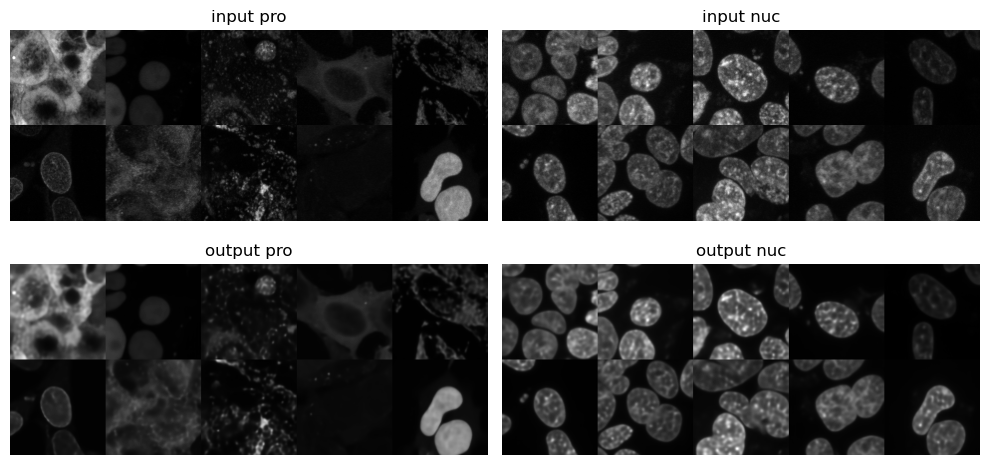

In [2]:
batch = next(iter(pdm.val_dataloader(novel_proteins=False, shuffle=True)))
input_images = batch['image'].to('cuda')
output_images = clm.sample(input_images)
output_images = output_images.detach().cpu().numpy()
input_images = input_images.detach().cpu().numpy()

size = input_images.shape[-1]
data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * size, 5 * size))
    for i, im in enumerate(input_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * size : (i0 + 1) * size, i1 * size : (i1 + 1) * size] = im
    t1 = np.zeros((2 * size, 5 * size))
    for i, im in enumerate(output_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * size : (i0 + 1) * size, i1 * size : (i1 + 1) * size] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [3]:
dl = pdm.val_dataloader(novel_proteins=False, shuffle=False)

In [6]:
pdm.train_dataset.labels = pdm.train_dataset.labels[pdm.train_dataset.labels['localization'] != '']
dl = pdm.train_dataloader()

In [7]:
import torch
from tqdm import tqdm


embeddings = []
localizations = []
complexes = []
complexes_fig = []
names = []
with torch.no_grad():
    for batch in tqdm(dl):
        emb = clm.encode(batch['image'].to('cuda'))
        embeddings.append(emb.detach().cpu().numpy())
        localizations.append(batch['localization'])
        complexes.append(batch['complex'])
        complexes_fig.append(batch['complex_fig'])
        names.append(batch['name'])
complexes = np.concatenate(complexes, axis=0)
complexes_fig = np.concatenate(complexes_fig, axis=0)
localizations = np.concatenate(localizations, axis=0)
embeddings = np.concatenate(embeddings, axis=0)
names = np.concatenate(names, axis=0)

100%|██████████| 4282/4282 [05:19<00:00, 13.41it/s]


In [10]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/autoencoder-data/"
zarr_path = join(datapath, "embeddings_2.zarr")

# shape = embeddings.shape
# chunks = (100, None, None, None)
# z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
# z[:] = embeddings

# np.save(join(datapath, "localizations_2.npy"), localizations)
# np.save(join(datapath, "names_2.npy"), names)
# np.save(join(datapath, "complexes_2.npy"), complexes)
# np.save(join(datapath, "complexes_fig_2.npy"), complexes_fig)

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
localizations = np.load(join(datapath, "localizations_2.npy"))
names = np.load(join(datapath, "names_2.npy"))
complexes = np.load(join(datapath, "complexes_2.npy"))
complexes_fig = np.load(join(datapath, "complexes_fig_2.npy"))


In [8]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/autoencoder-data/"
zarr_path = join(datapath, "embeddings_2_train.zarr")

shape = embeddings.shape
chunks = (100, None, None, None)
z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
z[:] = embeddings

np.save(join(datapath, "localizations_2_train.npy"), localizations)
np.save(join(datapath, "names_2_train.npy"), names)
np.save(join(datapath, "complexes_2_train.npy"), complexes)
np.save(join(datapath, "complexes_fig_2_train.npy"), complexes_fig)

# embeddings_train = np.asarray(zarr.open(zarr_path, mode='r'))
# localizations_train = np.load(join(datapath, "localizations_2_train.npy"))
# names_train = np.load(join(datapath, "names_2_train.npy"))
# complexes_train = np.load(join(datapath, "complexes_2_train.npy"))
# complexes_fig_train = np.load(join(datapath, "complexes_fig_2_train.npy"))


In [9]:
embeddings_train = embeddings
localizations_train = localizations
names_train = names
complexes_train = complexes
complexes_fig_train = complexes_fig

In [11]:
localizations[localizations == ''] = 'other'
complexes[complexes == ''] = 'other'
complexes_fig[complexes_fig == ''] = 'other'

In [12]:
localizations_train[localizations_train == ''] = 'other'
complexes_train[complexes_train == ''] = 'other'
complexes_fig_train[complexes_fig_train == ''] = 'other'

In [13]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [14]:
from joblib import dump
from joblib import load

dump(reducer, join(datapath,'umap_model_2.joblib'))

# reducer = load(join(datapath,'umap_model_2.joblib'))

['/home/ec2-user/autoencoder-data/umap_model_2.joblib']

In [15]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

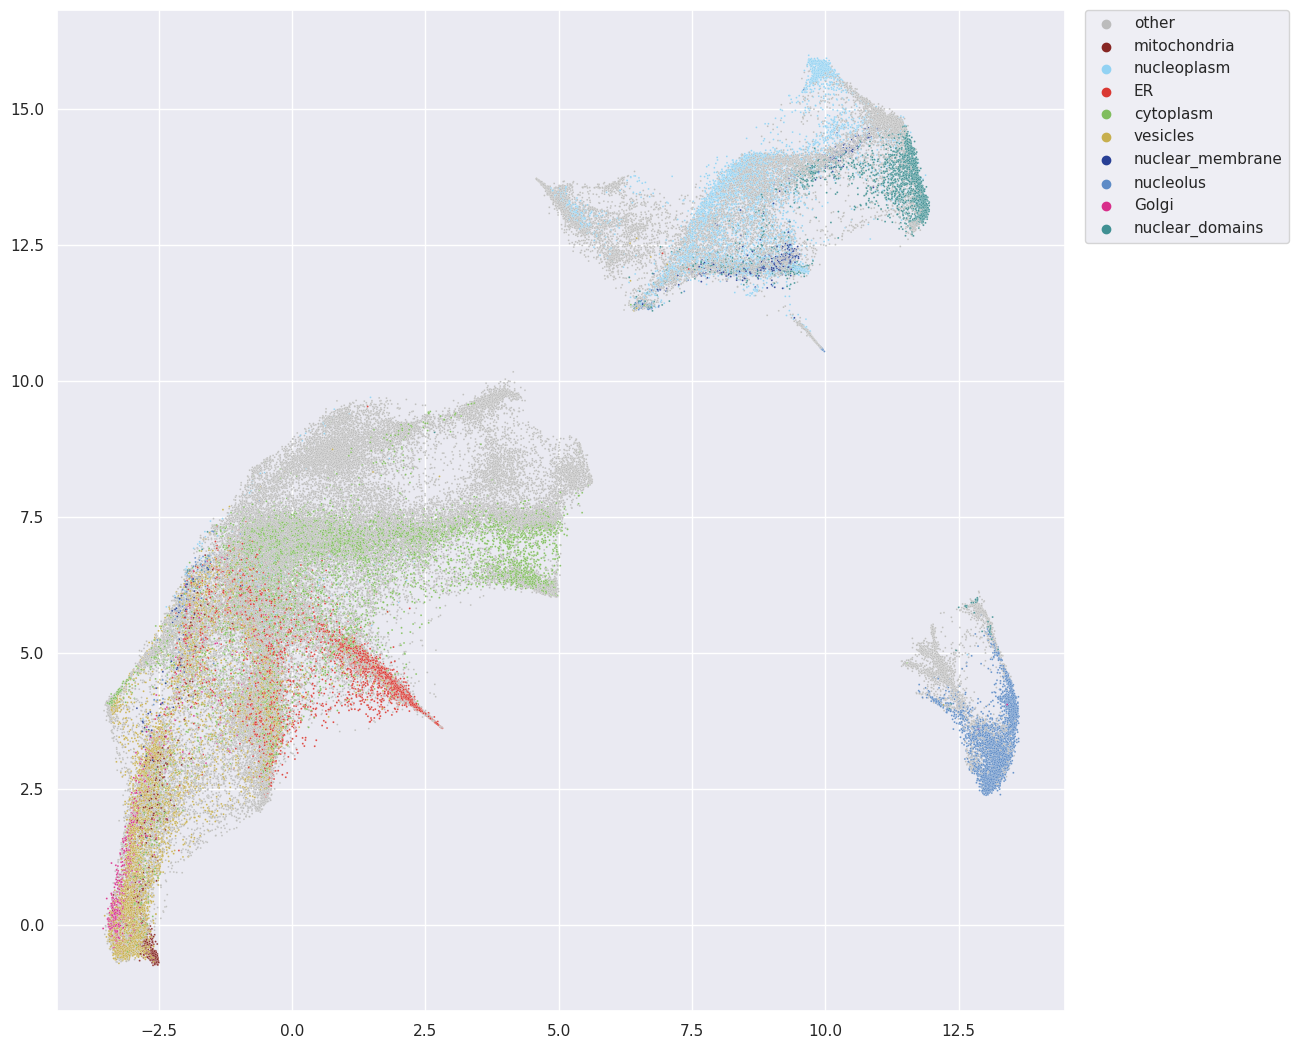

In [18]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

In [19]:
print(embeddings.max())
print(embeddings.min())

10.501887321472168
-7.183016777038574


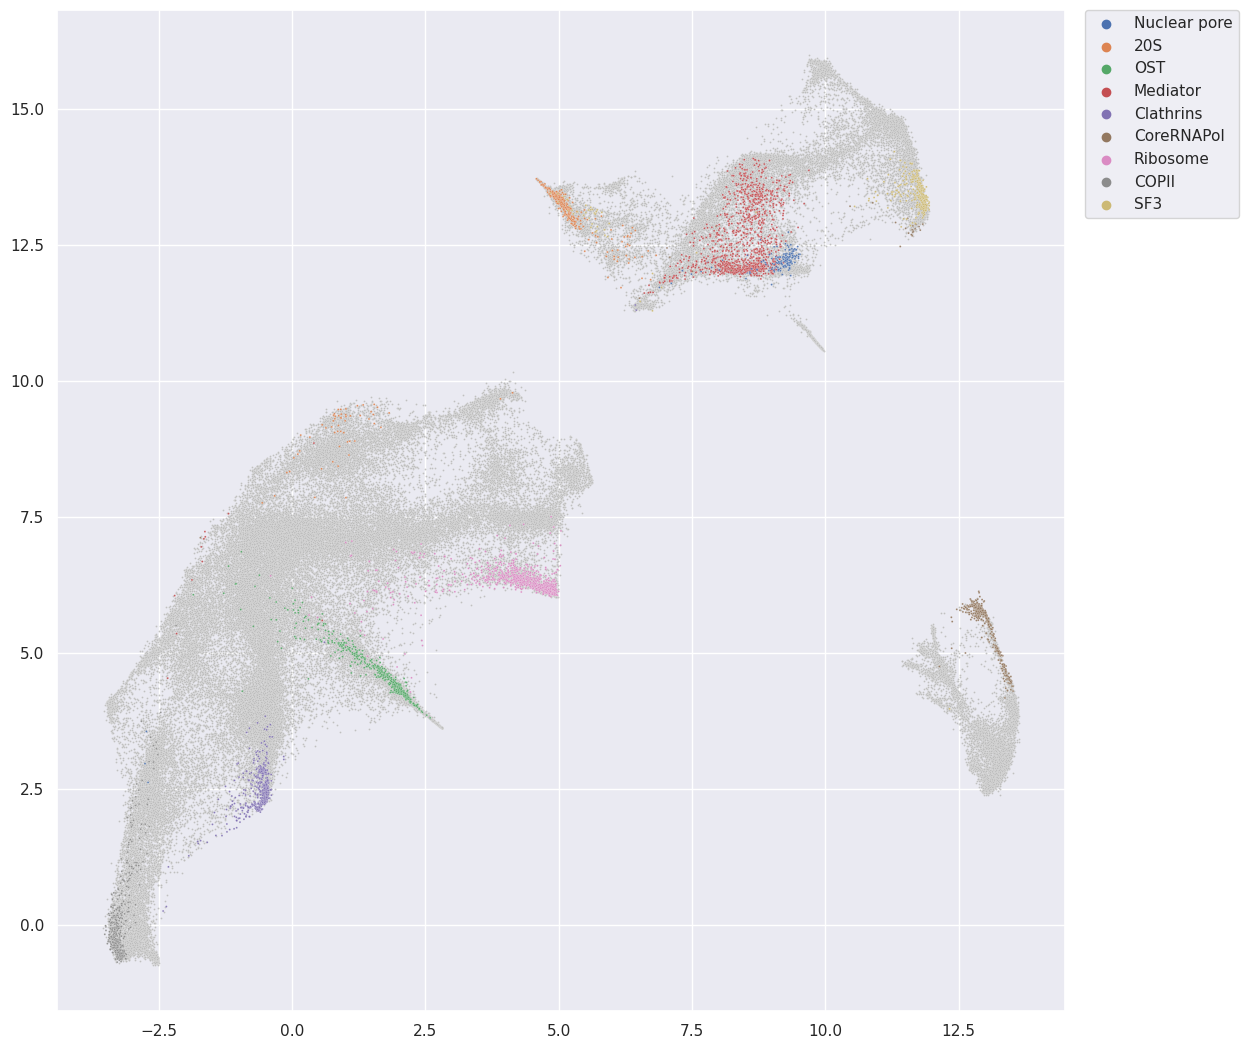

In [20]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=complexes_fig[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

In [21]:
# sns.set(rc={"figure.figsize":(13, 13)})
# other = complexes_fig != 'Ribosome'
# sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
# re = reduced_embedding[~other]
# n = names[~other]
# p = np.random.permutation(len(n))
# sns.scatterplot(x=re[p, 0], y=re[p, 1], hue=n[p], s=2, alpha=0.9)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
# plt.xlim([5, 10])
# plt.ylim([16.5, 21.5])

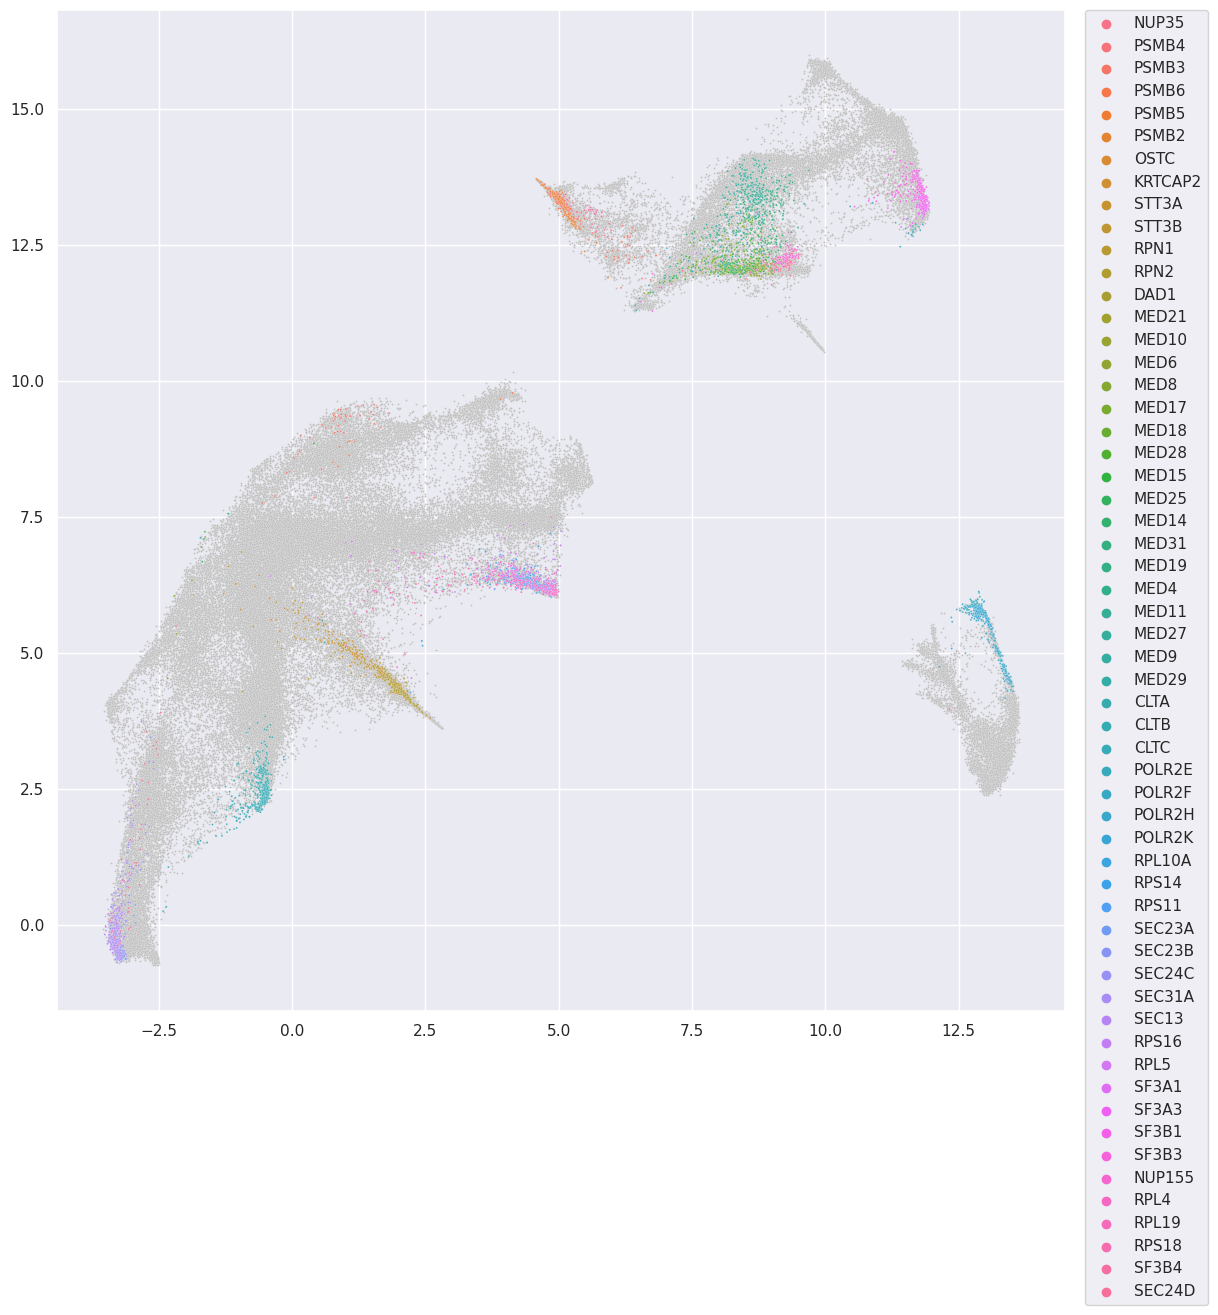

In [22]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=names[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

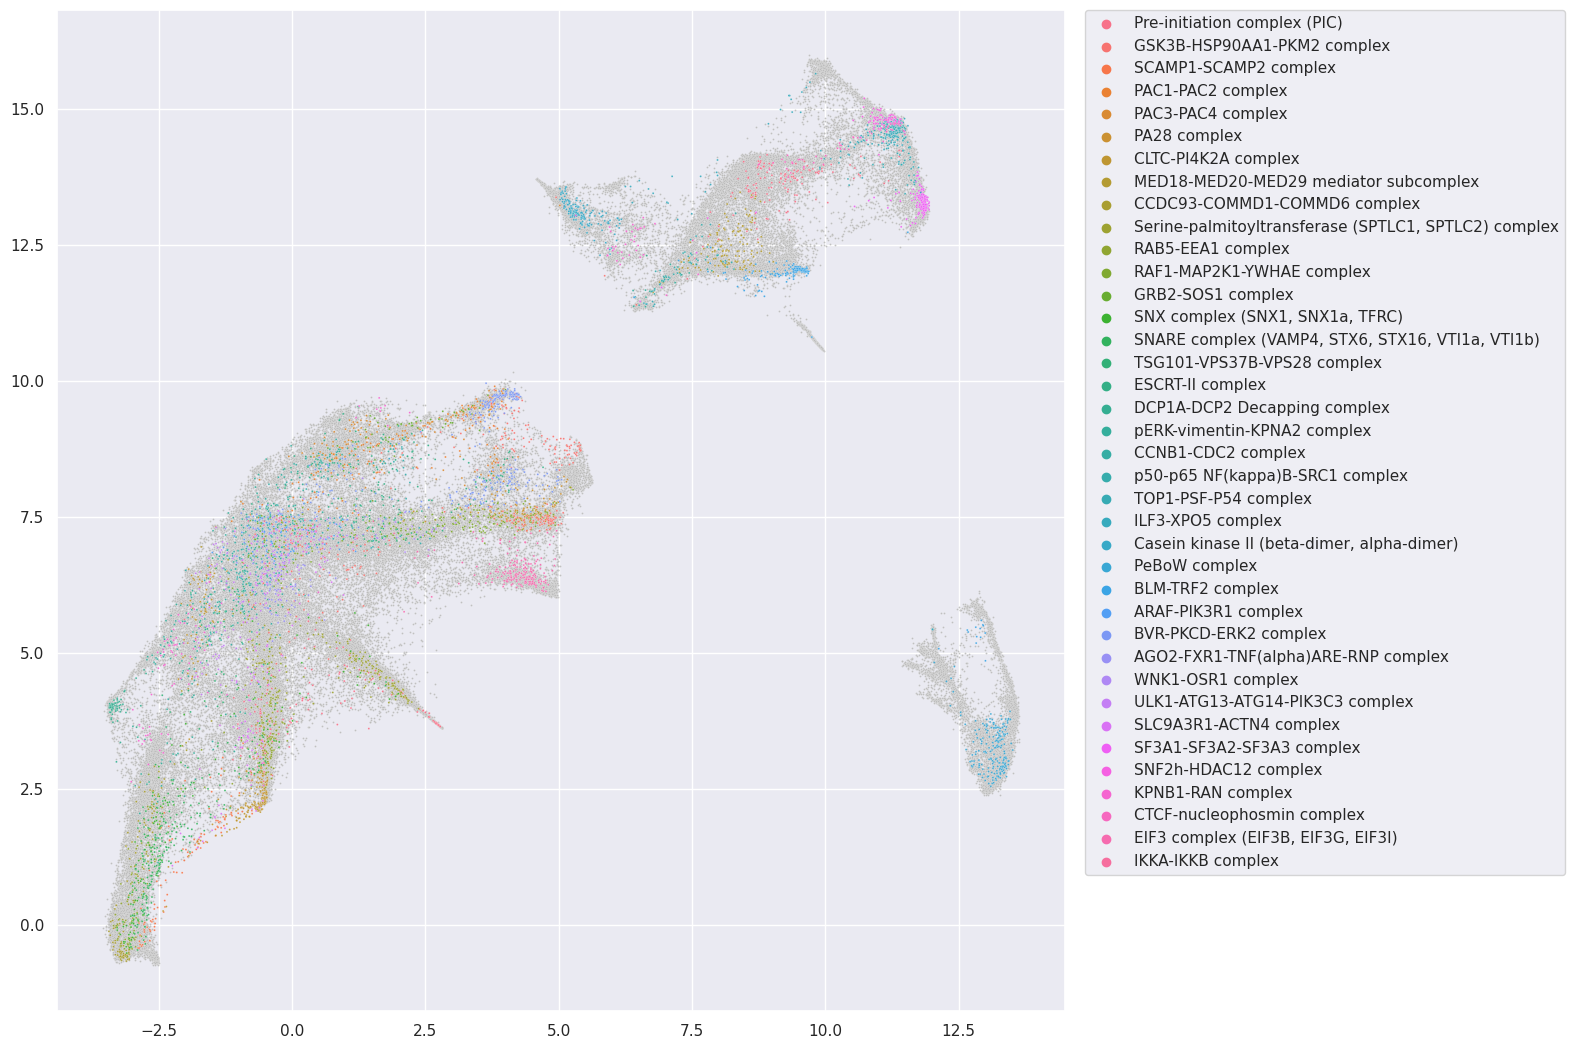

In [23]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=complexes[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### Score clustering

In [24]:
def robust_mean(cluster):
    return np.median(cluster, axis=0)


def robust_std(cluster):
    # Compute the median sum of square distance
    median = robust_mean(cluster)
    std = np.median(np.sqrt(((cluster - median)**2).sum(axis=1)), axis=0)
    return std


def clustering_score(clusters):
    means = [robust_mean(cluster) for cluster in clusters]
    stds = [robust_std(cluster) for cluster in clusters]
    
    # numerator = robust_std(means)
    # denominator = robust_mean(stds)

    numerator = np.std(means, axis=0)
    denominator = np.median(stds, axis=0)


    individual_scores = numerator / denominator
    
    # Assuming that you want to average the individual scores for the final score
    final_score = np.mean(individual_scores)
    
    return final_score

In [25]:
labels = np.unique(localizations)
labels = labels[labels != 'other']
clusters = [reduced_embedding[localizations == label] for label in labels]
print(np.mean([len(c) for c in clusters]))
clustering_score(clusters)

3766.222222222222


4.851266

In [26]:
# labels = np.unique(complexes)
# labels = labels[labels != 'other']
import pandas as pd

X = pd.DataFrame({'complexes':complexes, 'names':names}).drop_duplicates('names')
Z = X.value_counts('complexes')
Z = Z[Z.index != 'other']
labels = list(Z[Z != 1].index)

clusters = [reduced_embedding[complexes == label] for label in labels]
print(np.mean([len(c) for c in clusters]))
clustering_score(clusters)

194.57142857142858


4.009304

In [27]:
len(labels)

28

### Logistic regression for organelle classification

In [28]:
from sklearn.linear_model import LogisticRegression

other = localizations_train == 'other'
X_train = embeddings_train[~other]
X_train = X_train.reshape((X_train.shape[0], -1))
y_train = localizations_train[~other]

other = localizations == 'other'
X_test = embeddings[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = localizations[~other]

In [29]:
np.unique(localizations_train)

array(['ER', 'Golgi', 'cytoplasm', 'mitochondria', 'nuclear_domains',
       'nuclear_membrane', 'nucleolus', 'nucleoplasm', 'vesicles'],
      dtype='<U16')

In [30]:
clf = LogisticRegression(random_state=0, penalty='l2', C=1.0).fit(X_train, y_train)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
from joblib import load
from joblib import dump

# Save the model to a file
dump(clf, join(datapath,'localization_classifier_2.joblib'))

# # Load the model from the file
# clf = load(join(datapath,'localization_classifier_2.joblib'))


['/home/ec2-user/autoencoder-data/localization_classifier_2.joblib']

In [32]:
y_predict = clf.predict(X_test)

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_train)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.8625796554165683


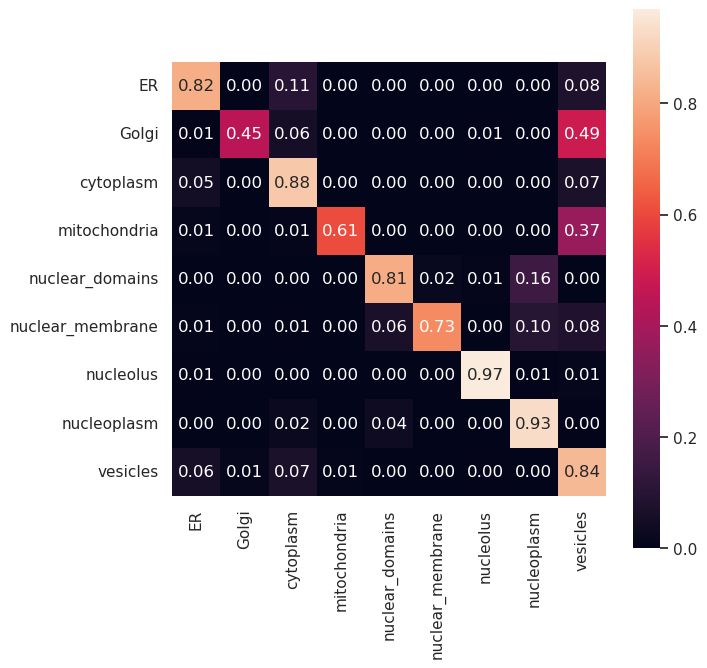

: 

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


## CORUM data

In [26]:
np.unique(complexes)

array(['AGO2-FXR1-TNF(alpha)ARE-RNP complex', 'ARAF-PIK3R1 complex',
       'BLM-TRF2 complex', 'BVR-PKCD-ERK2 complex',
       'CCDC93-COMMD1-COMMD6 complex', 'CCNB1-CDC2 complex',
       'CLTC-PI4K2A complex', 'CTCF-nucleophosmin complex',
       'Casein kinase II (beta-dimer, alpha-dimer)',
       'DCP1A-DCP2 Decapping complex',
       'EIF3 complex (EIF3B, EIF3G, EIF3I)', 'ESCRT-II complex',
       'GRB2-SOS1 complex', 'GSK3B-HSP90AA1-PKM2 complex',
       'IKKA-IKKB complex', 'ILF3-XPO5 complex', 'KPNB1-RAN complex',
       'MED18-MED20-MED29 mediator subcomplex', 'PA28 complex',
       'PAC1-PAC2 complex', 'PAC3-PAC4 complex', 'PeBoW complex',
       'Pre-initiation complex (PIC)', 'RAB5-EEA1 complex',
       'RAF1-MAP2K1-YWHAE complex', 'SCAMP1-SCAMP2 complex',
       'SF3A1-SF3A2-SF3A3 complex', 'SLC9A3R1-ACTN4 complex',
       'SNARE complex (VAMP4, STX6, STX16, VTI1a, VTI1b)',
       'SNF2h-HDAC12 complex', 'SNX complex (SNX1, SNX1a, TFRC)',
       'Serine-palmitoyltransferas

In [27]:
X = pd.DataFrame({'complexes':complexes, 'names':names}).drop_duplicates('names')

In [28]:
X

,complexes,names
0,Pre-initiation complex (PIC),ACTB
160,other,AHSA1
290,other,BAG4
374,other,BAG6
484,other,CDC37
...,...,...
91358,other,FAM207A
91468,other,C4orf32
91594,other,FAM117B
91651,other,TIA1


In [29]:
Z = X.value_counts('complexes')

In [30]:
Z = Z[Z.index != 'other']

In [31]:
list(Z[Z != 1].index)

['SNARE complex (VAMP4, STX6, STX16, VTI1a, VTI1b)',
 'pERK-vimentin-KPNA2 complex',
 'Pre-initiation complex (PIC)',
 'RAF1-MAP2K1-YWHAE complex',
 'GSK3B-HSP90AA1-PKM2 complex',
 'PeBoW complex',
 'BVR-PKCD-ERK2 complex',
 'TOP1-PSF-P54 complex',
 'Serine-palmitoyltransferase (SPTLC1, SPTLC2) complex',
 'PAC3-PAC4 complex',
 'TSG101-VPS37B-VPS28 complex',
 'SLC9A3R1-ACTN4 complex',
 'SF3A1-SF3A2-SF3A3 complex',
 'ULK1-ATG13-ATG14-PIK3C3 complex',
 'RAB5-EEA1 complex',
 'p50-p65 NF(kappa)B-SRC1 complex',
 'SNX complex (SNX1, SNX1a, TFRC)',
 'PAC1-PAC2 complex',
 'MED18-MED20-MED29 mediator subcomplex',
 'KPNB1-RAN complex',
 'ILF3-XPO5 complex',
 'BLM-TRF2 complex',
 'CCDC93-COMMD1-COMMD6 complex',
 'ESCRT-II complex',
 'EIF3 complex (EIF3B, EIF3G, EIF3I)',
 'PA28 complex',
 'CCNB1-CDC2 complex',
 'CLTC-PI4K2A complex']

In [32]:
Z.value_counts()

2    21
1    10
3     6
4     1
dtype: int64

In [33]:
21 + 3 * 6 + 6

45